In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import regex as re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
import keras_tuner as kt
from gensim.models import KeyedVectors, Word2Vec
from sklearn.decomposition import TruncatedSVD
from keras.layers import Activation
from keras import activations
import scipy
import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, average_precision_score
from sklearn.manifold import TSNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Cleaning

In [ ]:
df = pd.read_csv('drive/MyDrive/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.loc[df.review.isna()]  # 0 NaN values

,review,sentiment


In [ ]:
df.loc[0,'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
df['review'] = df.review.str.replace(r'<br /><br />', ' ')  # replace <br /><br /> with a whitespace

In [ ]:
stop_words = Counter(stopwords.words('english'))  # faster look-up if dictionary
stop_words.pop("not")
stop_words.pop("no")

def review_cleaner(review, stop_words):
    review = re.sub(r"[^a-zA-Z]", " ", review)
    review = re.sub(r'\s+', ' ', review, flags=re.I)  # flags to ignore case
    reduced_review = [word for word in review.lower().split() if word not in stop_words and len(word) > 1]
    return ' '.join(reduced_review)

In [ ]:
df['review'] = df.review.apply(lambda x: review_cleaner(x, stop_words))

In [ ]:
df.loc[0, 'review']

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due la

In [ ]:
df.sentiment.replace({'positive': 1, 'negative': 0}, inplace=True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


#### Dataset Exploration

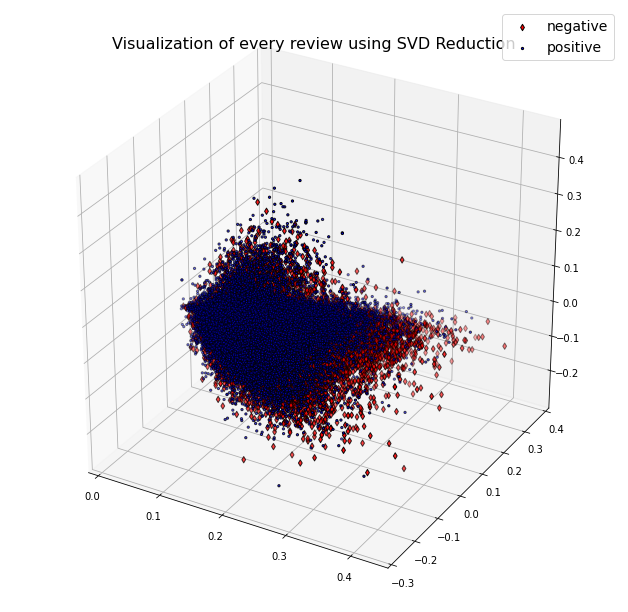

In [ ]:
X_Total = TfidfVectorizer().fit_transform(df.review.tolist())  # tfidf the whole dataset
svd = TruncatedSVD(n_components=3)  # Svd and only keep three columns
svd_x = svd.fit_transform(X_Total)

fig = plt.figure(figsize=(11,11))
fig.patch.set_alpha(1)

ax= fig.add_subplot(111, projection='3d')
ax.scatter(svd_x[df.sentiment.to_numpy()==0,0], svd_x[df.sentiment.to_numpy()==0 ,1], svd_x[df.sentiment.to_numpy()==0,2], 
            c='r', edgecolor='k', marker='d', label='negative')
ax.scatter(svd_x[df.sentiment.to_numpy()==1,0], svd_x[df.sentiment.to_numpy()==1 ,1], svd_x[df.sentiment.to_numpy()==1,2], 
            c='b', edgecolor='k', marker='.', label='positive')
ax.set_title('Visualization of every review using SVD Reduction', fontsize=16)
ax.legend(fontsize=14)

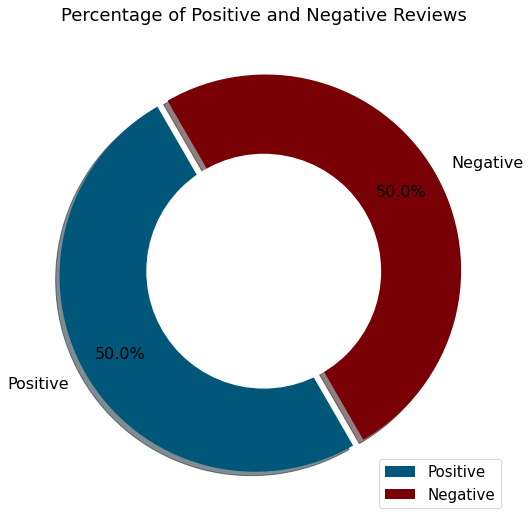

In [ ]:
fig = plt.figure(figsize=(10,9))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

labels = ['Positive', 'Negative']
colors = ['#005779', '#790005']
ax.pie(df.sentiment.value_counts().tolist(), colors=colors, autopct='%.1f%%', labels=labels,
        pctdistance=0.8, textprops={'fontsize': 16}, startangle=120, shadow=0.9, explode=(0.05,0.01))
ax.legend(labels, loc='lower right', fontsize=15)
ax.set_title('Percentage of Positive and Negative Reviews', fontsize=18)

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

In [ ]:
vocab_size = len(set([word for sent in df.review.tolist() for word in sent.split()]))
print(f'The dataset contains {len(df.review.tolist())} reviews and {vocab_size} unique words (after cleaning).')

n_words = [len(sent.split()) for sent in df.review.tolist()]
avg_review_len = np.mean(n_words)
std_review_len = np.std(n_words)
print(f'The average number of words in a review is {round(avg_review_len)} with a standard deviation of {round(std_review_len)}')

The dataset contains 50000 reviews and 99257 unique words (after cleaning).
The average number of words in a review is 120 with a standard deviation of 90


### Modelling

In [ ]:
#split sets
X_train, X_val, y_train, y_val = train_test_split(df.review, df.sentiment, test_size=0.3, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.7, random_state=0)

#### Pretrained Word2Vec Word Embeddings

In [ ]:
X_train_words = [sent.split() for sent in X_train]  # list with all the words from each sentence

In [ ]:
filename = 'GoogleNews-vectors-negative300.bin'  # W2V
w2v_emb = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
tokenizer = Tokenizer()  # Create an instance of the tokenizer
tokenizer.fit_on_texts(X_train)  # tokenize the training set

v_size = len(tokenizer.word_index) + 1  # +1 for the padding

#### Visualizing the word embeddings

In [ ]:
original= []
emb_clusters = []
similar_words = []

for word in list(tokenizer.word_index.keys())[:151:15]:  # find the similar words of 11 words in the vocabulary
    original.append(word)  # will be used as a label
    similar = []
    embeddings = []

    for sim_w, _ in w2v_emb.most_similar(word):
        similar.append(sim_w)
        embeddings.append(w2v_emb[sim_w])

    similar_words.append(similar)
    emb_clusters.append(embeddings)

In [ ]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=42)  # reduce to 2 dimensions for plotting
embedding_clusters = np.array(emb_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

C:\Users\steli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\steli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


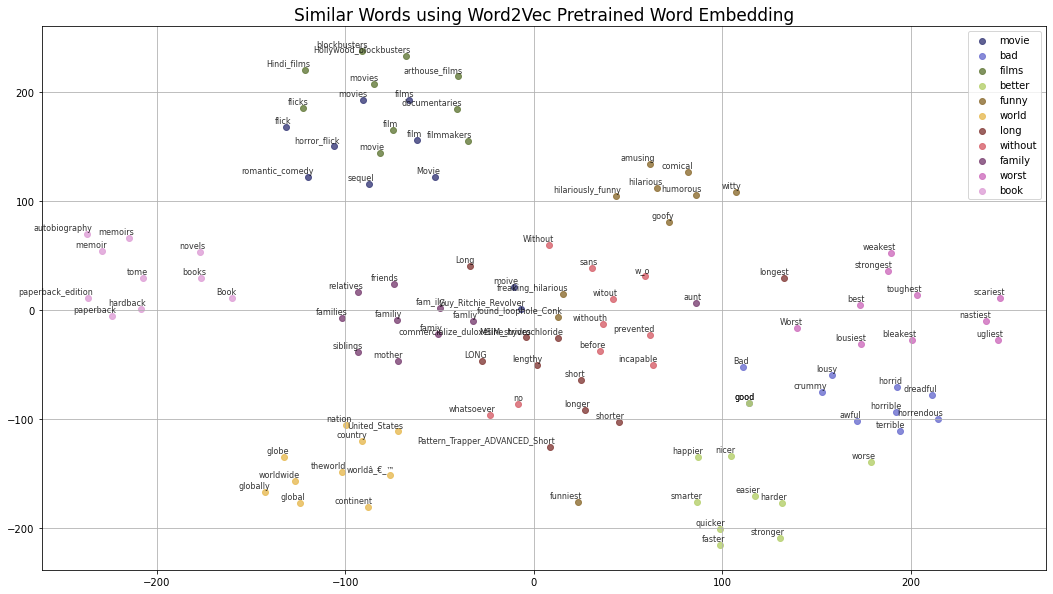

In [ ]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.8):
    fig = plt.figure(figsize=(18, 10))
    fig.patch.set_alpha(1)
    colors = cm.tab20b(np.linspace(0, 1, len(labels)))  # create colormap for different labels

    ax = fig.add_subplot(111)
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        ax.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_title('Similar Words using Word2Vec Pretrained Word Embedding', fontsize=17)

    return plt.show()


tsne_plot_similar_words(original, embeddings_en_2d, similar_words)

In [ ]:
print(f'The vocabulary contains {len(tokenizer.word_index)} unique words.')

The vocabulary contains 86702 unique words.


In [ ]:
# Convert the sets to a sequence of unique indices that were attached to each voacabulary words
train_sequences = tokenizer.texts_to_sequences(X_train)
dev_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
sent_lengths = [len(s.split()) for s in X_train]
mean_l_sent = np.mean(sent_lengths)
std_l_sent = np.std(sent_lengths)

max_len = round(mean_l_sent + std_l_sent)

# pad/trim the sentences so that all of them have the same length. The length that was chosen was the mean + the standard deviation of words from all the sentences
train_padded = pad_sequences(train_sequences, maxlen=max_len, truncating='post', padding='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
def embedding_matrix_creator(tokenizer, embeddings_dict, dim):  # create an embedding matrix using the pretrained embeddings
    embedding_matrix = np.zeros((v_size, dim))
    missed_words = []

    for word,i in tokenizer.word_index.items():
        if i < v_size:
            try:
                emb_vec = embeddings_dict[word]
            except:
                emb_vec = None
                missed_words.append(word)  # count the words that were not found in the embeddings vocabulary
                
            if emb_vec is not None:
                embedding_matrix[i] = emb_vec
            
    return embedding_matrix, missed_words

In [ ]:
embedding_matrix, miss = embedding_matrix_creator(tokenizer, w2v_emb, 300)  # create embeddings matrix

In [ ]:
print(f'{len(miss)} out of the total {v_size} words were not found in the embeddings dictionary.')

32907 out of the total 86703 words were not found in the embeddings dictionary.


In [ ]:
model = Sequential()
model.add(Embedding(v_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 300)          26010900  
                                                                 
 flatten_1 (Flatten)         (None, 63000)             0         
                                                                 
 dropout_3 (Dropout)         (None, 63000)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                4032064   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

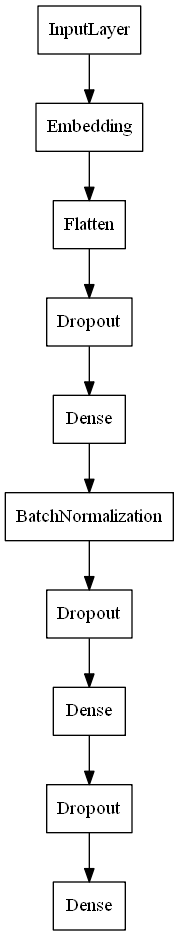

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=False)  # Visualize the model

In [ ]:
history = model.fit(train_padded, np.array(y_train), epochs=1000, batch_size=16,
                    validation_data=(dev_padded, np.array(y_val)), callbacks=[es])

Epoch 1/1000
2188/2188 [==============================] - 56s 25ms/step - loss: 0.6790 - accuracy: 0.6197 - val_loss: 0.5007 - val_accuracy: 0.7724
Epoch 2/1000
2188/2188 [==============================] - 55s 25ms/step - loss: 0.5443 - accuracy: 0.7365 - val_loss: 0.4589 - val_accuracy: 0.7944
Epoch 3/1000
2188/2188 [==============================] - 55s 25ms/step - loss: 0.4919 - accuracy: 0.7774 - val_loss: 0.4335 - val_accuracy: 0.8084
Epoch 4/1000
2188/2188 [==============================] - 55s 25ms/step - loss: 0.4635 - accuracy: 0.7962 - val_loss: 0.4223 - val_accuracy: 0.8150
Epoch 5/1000
2188/2188 [==============================] - 55s 25ms/step - loss: 0.4412 - accuracy: 0.8137 - val_loss: 0.4198 - val_accuracy: 0.8113
Epoch 6/1000
2188/2188 [==============================] - 55s 25ms/step - loss: 0.4289 - accuracy: 0.8187 - val_loss: 0.4146 - val_accuracy: 0.8149
Epoch 7/1000
2188/2188 [==============================] - 54s 25ms/step - loss: 0.4125 - accuracy: 0.8295 - val_

In [ ]:
model.evaluate(test_padded, np.array(y_test))

141/141 [==============================] - 1s 7ms/step - loss: 0.4020 - accuracy: 0.8253


[0.40195491909980774, 0.8253333568572998]

In [ ]:
def acc_loss_plot(history):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle("Training/Validation Results", fontsize=17)
    fig.patch.set_alpha(1)
    for i in range(0, 2):
        ax = fig.add_subplot(1,2,i+1)
        ax.plot(history.history[list(history.history.keys())[i]], c='r', label='Training Loss' if i==0 else 'Training Accuracy')
        ax.plot(history.history[list(history.history.keys())[i+2]], c='k',
                label='Validation Loss' if i==0 else 'Validation Accuracy')
        ax.legend(fontsize=11, loc='lower right' if i==1 else 'upper right')
        ax.set_xlabel("Epochs", fontsize=14)
        ax.set_ylabel("Loss" if i==0 else "Accuracy", fontsize=15)

    return plt.show()

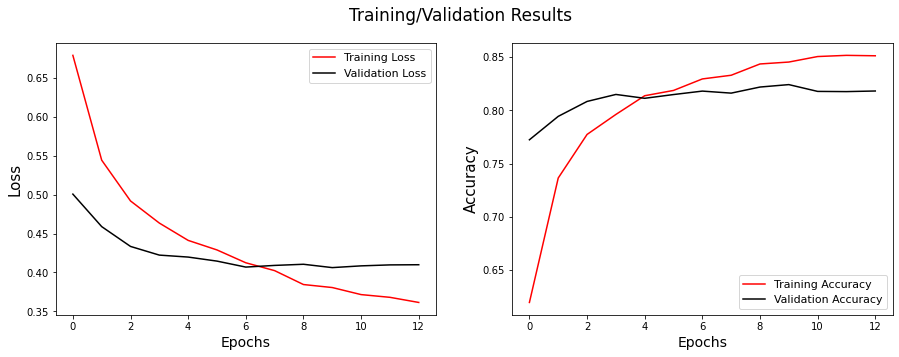

In [ ]:
acc_loss_plot(history)

#### Word2Vec Custom Embeddings

In [ ]:
w2v_embeddings = Word2Vec(sentences=X_train_words, min_count=1, size=100, iter=15) # create new embeddings using the training set

w2v_matrix, miss = embedding_matrix_creator(tokenizer, w2v_embeddings.wv, 100)  # create embedding matrix

In [ ]:
model2 = Sequential()
# initialize the embeddings matrix with the w2v embeddings and then re-train them
model2.add(Embedding(v_size, 100, weights=[w2v_matrix], input_length=max_len, trainable=True, mask_zero=True))
model2.add(Flatten())
model2.add(Dropout(0.6))
model2.add(Dense(128))
model2.add(Activation(activations.relu))
model2.add(BatchNormalization())
model2.add(Dropout(0.6))
model2.add(Dense(64))
model2.add(Activation(activations.relu))
model2.add(Dropout(0.7))
model2.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 210, 100)          8670300   
                                                                 
 flatten_4 (Flatten)         (None, 21000)             0         
                                                                 
 dropout_12 (Dropout)        (None, 21000)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               2688128   
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                      

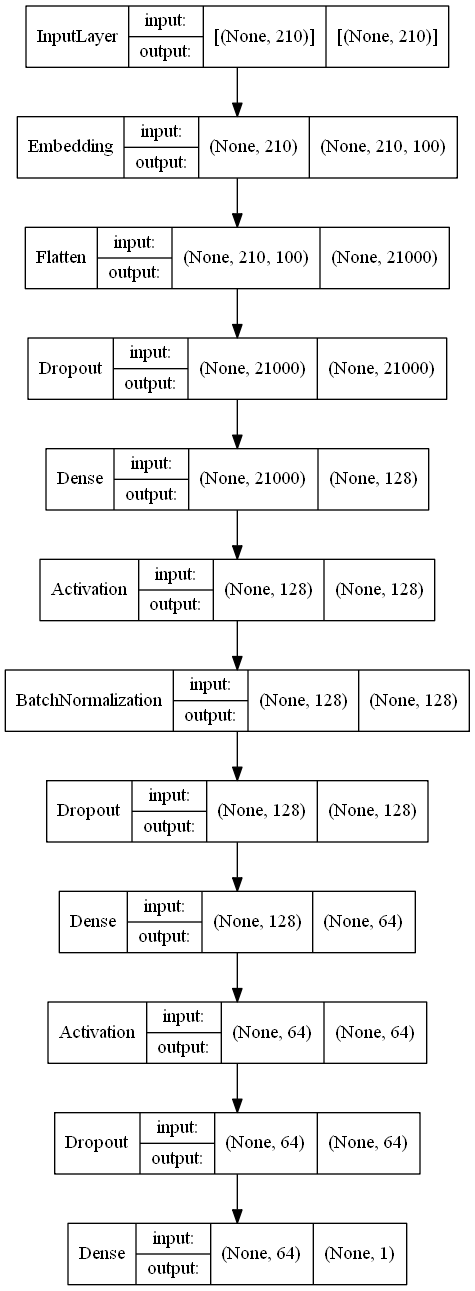

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=False) # Visualize the model

In [ ]:
history2 = model2.fit(train_padded, np.array(y_train), epochs=1000, batch_size=64,
                    validation_data=(dev_padded, np.array(y_val)), callbacks=[es])

Epoch 1/1000
547/547 [==============================] - 61s 110ms/step - loss: 0.7242 - accuracy: 0.6805 - val_loss: 0.4179 - val_accuracy: 0.8211
Epoch 2/1000
547/547 [==============================] - 61s 112ms/step - loss: 0.4515 - accuracy: 0.7935 - val_loss: 0.3666 - val_accuracy: 0.8393
Epoch 3/1000
547/547 [==============================] - 60s 110ms/step - loss: 0.3968 - accuracy: 0.8286 - val_loss: 0.3435 - val_accuracy: 0.8545
Epoch 4/1000
547/547 [==============================] - 60s 110ms/step - loss: 0.3558 - accuracy: 0.8476 - val_loss: 0.3345 - val_accuracy: 0.8556
Epoch 5/1000
547/547 [==============================] - 60s 109ms/step - loss: 0.3261 - accuracy: 0.8618 - val_loss: 0.3191 - val_accuracy: 0.8645
Epoch 6/1000
547/547 [==============================] - 60s 109ms/step - loss: 0.2995 - accuracy: 0.8774 - val_loss: 0.3138 - val_accuracy: 0.8671
Epoch 7/1000
547/547 [==============================] - 60s 109ms/step - loss: 0.2755 - accuracy: 0.8873 - val_loss: 0

In [ ]:
model2.evaluate(test_padded, np.array(y_test))

141/141 [==============================] - 1s 5ms/step - loss: 0.2986 - accuracy: 0.8833


[0.2986389696598053, 0.8833333253860474]

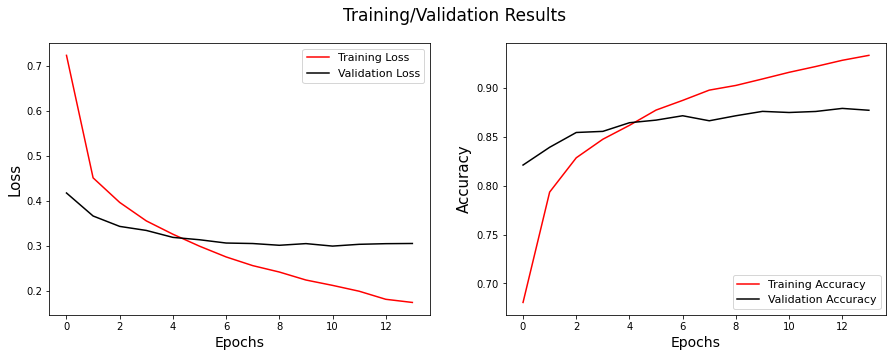

In [ ]:
acc_loss_plot(history2)

#### TF-IDF


In [ ]:
#vectorize X_train set
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = 7000, sublinear_tf=True)

#tranform the rest accordingly
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

#sort indexes of sparse matrix as required for the neural network input
scipy.sparse.csr_matrix.sort_indices(X_train_tfidf)
scipy.sparse.csr_matrix.sort_indices(X_val_tfidf)

In [ ]:
#create method with "dummy" neural network. Random combinations of choices will be run
def build_m(hp):

  model = Sequential()

  for i in range(hp.Int("num_layers", 1, 3)):
    model.add(Dense(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), activation="relu"))
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.5))

  model.add(Dense(1,  activation='sigmoid'))

  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

  return model


In [ ]:
#initialize keras tuner
tuner = kt.RandomSearch(
    hypermodel=build_m,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="best_params"
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
#run the tuner
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner.search(X_train_tfidf, np.array(y_train), epochs=1000, verbose=1, 
                validation_data=(X_val_tfidf, np.array(y_val)), callbacks=[es], batch_size=64)

Trial 52 Complete [00h 00m 08s]
val_loss: 0.2522338628768921

Best val_loss So Far: 0.2465207427740097
Total elapsed time: 00h 54m 17s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#print results
tuner.results_summary()

Results summary
Results in best_params\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 288
dropout: True
lr: 0.000130573118342512
units_1: 128
units_2: 352
Score: 0.2465207427740097
Trial summary
Hyperparameters:
num_layers: 1
units_0: 384
dropout: True
lr: 0.00011551879589796051
units_1: 448
units_2: 320
Score: 0.24654671549797058
Trial summary
Hyperparameters:
num_layers: 2
units_0: 128
dropout: True
lr: 0.00016271155685990062
units_1: 96
units_2: 384
Score: 0.2468373328447342
Trial summary
Hyperparameters:
num_layers: 1
units_0: 288
dropout: False
lr: 0.0002657084336873485
units_1: 384
units_2: 96
Score: 0.24734383821487427
Trial summary
Hyperparameters:
num_layers: 2
units_0: 64
dropout: True
lr: 0.00012495535612235057
units_1: 512
units_2: 128
Score: 0.24821916222572327
Trial summary
Hyperparameters:
num_layers: 1
units_0: 96
dropout: False
lr: 0.0005769877763389441
units_1: 320
units_2: 160


In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
best_model.build(input_shape=(None, 7000,7000))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7000, 288)         2016288   
                                                                 
 dropout (Dropout)           (None, 7000, 288)         0         
                                                                 
 dense_1 (Dense)             (None, 7000, 128)         36992     
                                                                 
 dropout_1 (Dropout)         (None, 7000, 128)         0         
                                                                 
 dense_2 (Dense)             (None, 7000, 1)           129       
                                                                 
Total params: 2,053,409
Trainable params: 2,053,409
Non-trainable params: 0
_________________________________________________________________


#### Final Neural Network

In [ ]:
#build neural netowk based on the tuner's best results
model3 = Sequential()
model3.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'))
model3.add(Dropout(rate=0.5))   
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00051), metrics=['accuracy'])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               896128    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 896,257
Trainable params: 896,257
Non-trainable params: 0
_________________________________________________________________


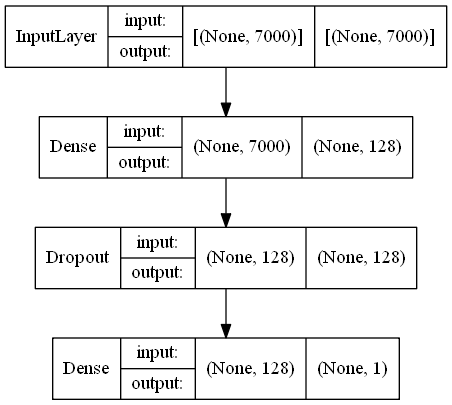

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=False)

In [ ]:
#initialize model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
history3 = model3.fit(X_train_tfidf, np.array(y_train), epochs=20, verbose=1,validation_data=(X_val_tfidf, np.array(y_val)), callbacks=[callback])

Epoch 1/20


C:\Users\steli\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1094/1094 [==============================] - 15s 13ms/step - loss: 0.3610 - accuracy: 0.8663 - val_loss: 0.2536 - val_accuracy: 0.8960
Epoch 2/20
1094/1094 [==============================] - 14s 13ms/step - loss: 0.2134 - accuracy: 0.9173 - val_loss: 0.2483 - val_accuracy: 0.8975
Epoch 3/20
1094/1094 [==============================] - 14s 13ms/step - loss: 0.1824 - accuracy: 0.9291 - val_loss: 0.2594 - val_accuracy: 0.8945
Epoch 4/20
1094/1094 [==============================] - 14s 13ms/step - loss: 0.1610 - accuracy: 0.9394 - val_loss: 0.2735 - val_accuracy: 0.8885


In [ ]:
#compute accuracy
loss, acc = model3.evaluate( X_test_tfidf.todense(), y_test)
print('Test Accuracy: %f' % (acc*100))

141/141 [==============================] - 1s 4ms/step - loss: 0.2386 - accuracy: 0.9056
Test Accuracy: 90.555555


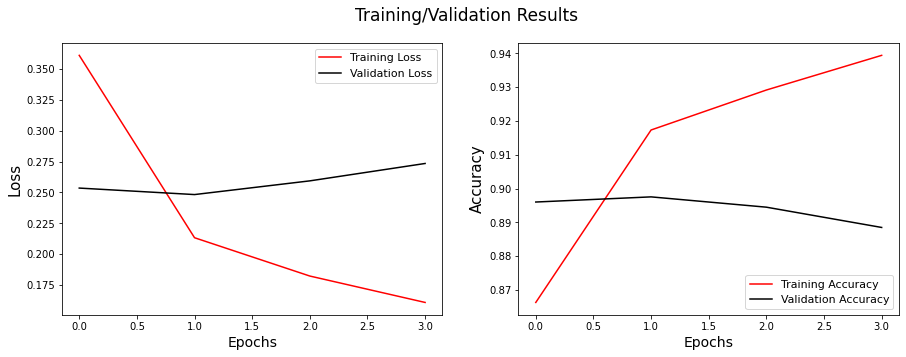

In [ ]:
acc_loss_plot(history3)

### Score Tables

In [ ]:
def score_func(model, X_test, y_test):
    """
    calculates and returns a dictionary with all the prediction scores
    """
    scores = {}
    
    yhat = np.where(model.predict(X_test) > 0.5, 1, 0).reshape(-1,)
    y_probs = model.predict(X_test)
    
    scores['Accuracy'] = accuracy_score(y_test, yhat)
    scores['Recall0'] = recall_score(y_test, yhat, average=None, labels=[0])[0]
    scores['Recall1'] = recall_score(y_test, yhat, average=None, labels=[1])[0]
    scores['Recall_macro'] = recall_score(y_test, yhat, average='macro')
    scores['Precision0'] = precision_score(y_test, yhat, average=None, labels=[0])[0]
    scores['Precision1'] = precision_score(y_test, yhat, average=None, labels=[1])[0]
    scores['Precision_macro'] = precision_score(y_test, yhat, average='macro')
    scores['F1_0'] = f1_score(y_test, yhat, average=None, labels=[0])[0]
    scores['F1_1'] = f1_score(y_test, yhat, average=None, labels=[1])[0]
    scores['F1_macro'] = f1_score(y_test, yhat, average='macro')
    scores['AUC0'] = average_precision_score(y_test, 1 - y_probs, pos_label = 0, average=None)
    scores['AUC1'] = average_precision_score(y_test, y_probs, pos_label = 1, average=None)
    scores['AUC_macro'] = average_precision_score(y_test, y_probs)
    
    return scores

In [ ]:
m1_test_scores = score_func(model, test_padded, np.array(y_test))
m1_dev_scores = score_func(model, dev_padded, np.array(y_val))
m1_train_scores = score_func(model, train_padded, np.array(y_train))

m2_test_scores = score_func(model2, test_padded, np.array(y_test))
m2_dev_scores = score_func(model2, dev_padded, np.array(y_val))
m2_train_scores = score_func(model2, train_padded, np.array(y_train))

m3_test_scores = score_func(model3, X_test_tfidf.todense(), np.array(y_test))
m3_dev_scores = score_func(model3, X_val_tfidf.todense(), np.array(y_val))
m3_train_scores = score_func(model3, X_train_tfidf.todense(), np.array(y_train))

In [ ]:
def scores_table(dictionaries):
    """
    -arg 'dictionaries' must be a list of dictionaries, where the first dictionary is the training scores,\n
    the second dictionary must be the development scores and the last dictionary the test scores
    """
    dict = {}
    for k in list(dictionaries[0].keys()):
        dict[k] = list(d[k] for d in dictionaries)
    
    df = pd.DataFrame.from_dict(dict, orient='index').rename(columns={0:'Training Set', 1: 'Development Set', 2:'Test Set'})
    return df

In [ ]:
model1_scores = scores_table([m1_train_scores, m1_dev_scores, m1_test_scores])
model2_scores = scores_table([m2_train_scores, m2_dev_scores, m2_test_scores])
model3_scores = scores_table([m3_train_scores, m3_dev_scores, m3_test_scores])

In [ ]:
model1_scores

,Training Set,Development Set,Test Set
Accuracy,0.943800,0.824190,0.825333
Recall0,0.940206,0.821591,0.831416
Recall1,0.947377,0.826820,0.819196
Recall_macro,0.943792,0.824205,0.825306
Precision0,0.946767,0.827547,0.822680
Precision1,0.940887,0.820844,0.828069
Precision_macro,0.943827,0.824196,0.825374
F1_0,0.943475,0.824558,0.827025
F1_1,0.944121,0.823821,0.823609
F1_macro,0.943798,0.824190,0.825317


In [ ]:
model2_scores

,Training Set,Development Set,Test Set
Accuracy,0.979629,0.874952,0.883333
Recall0,0.974399,0.848295,0.868142
Recall1,0.984835,0.901916,0.898661
Recall_macro,0.979617,0.875106,0.883401
Precision0,0.984606,0.897415,0.896300
Precision1,0.974776,0.854602,0.871051
Precision_macro,0.979691,0.876008,0.883676
F1_0,0.979476,0.872164,0.881996
F1_1,0.979779,0.877621,0.884641
F1_macro,0.979627,0.874893,0.883318


In [ ]:
model3_scores

,Training Set,Development Set,Test Set
Accuracy,0.942200,0.897524,0.905556
Recall0,0.939633,0.889773,0.906637
Recall1,0.944755,0.905364,0.904464
Recall_macro,0.942194,0.897568,0.905551
Precision0,0.944230,0.904854,0.905435
Precision1,0.940199,0.890354,0.905677
Precision_macro,0.942214,0.897604,0.905556
F1_0,0.941926,0.897250,0.906036
F1_1,0.942471,0.897796,0.905070
F1_macro,0.942199,0.897523,0.905553
